In [ ]:
import pandas as pd

# Load true.csv and false.csv
true_df = pd.read_csv('/content/politifact_real.csv')
false_df = pd.read_csv('/content/politifact_fake.csv')

# Add label column (1 for true news, 0 for false news)
true_df['label'] = 1
false_df['label'] = 0

# Merge the datasets
merged_df = pd.concat([true_df, false_df], ignore_index=True)

# Shuffle the merged dataset
merged_df = merged_df.sample(frac=1).reset_index(drop=True)

# Save the merged dataset with labels
merged_df.to_csv('merged_news.csv', index=False)


In [ ]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm
import pandas as pd

# Load your merged dataset
merged_df = pd.read_csv('merged_news.csv')

# Ensure 'text' column contains strings (if not, convert to string)
merged_df['text'] = merged_df['text'].astype(str)

# Load tokenizer and pre-trained RoBERTa model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

# Prepare input data and labels
texts = merged_df['text'].tolist()  # Extract text as a list of strings
labels = merged_df['label'].tolist()

# Tokenize input texts
encoded_data = tokenizer(texts, padding=True, truncation=True, return_tensors='pt')

# Split data into train and validation sets
train_inputs, val_inputs, train_labels, val_labels = train_test_split(
    encoded_data['input_ids'], labels, test_size=0.1, random_state=42)

train_masks, val_masks, _, _ = train_test_split(
    encoded_data['attention_mask'], labels, test_size=0.1, random_state=42)

# Create PyTorch datasets and data loaders
train_dataset = TensorDataset(train_inputs, train_masks, torch.tensor(train_labels))
val_dataset = TensorDataset(val_inputs, val_masks, torch.tensor(val_labels))

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Set up optimizer and training parameters
optimizer = AdamW(model.parameters(), lr=5e-5)

# Training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}'):
        batch = tuple(t.to(device) for t in batch)
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}

        optimizer.zero_grad()
        outputs = model(**inputs)

        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_loader)
    print(f'Average training loss: {avg_train_loss}')

# Save the fine-tuned model
model.save_pretrained('fine_tuned_roberta')



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1: 100%|██████████| 72/72 [20:34<00:00, 17.14s/it]


Average training loss: 0.4995580855756998


Epoch 2: 100%|██████████| 72/72 [20:00<00:00, 16.67s/it]


Average training loss: 0.32709283599009115


Epoch 3: 100%|██████████| 72/72 [20:07<00:00, 16.77s/it]


Average training loss: 0.2148287761439052


In [ ]:
# Evaluation function
def evaluate(model, data_loader):
    model.eval()
    preds = []
    true_labels = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc='Evaluating'):
            batch = tuple(t.to(device) for t in batch)
            inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': None}

            outputs = model(**inputs)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1)

            preds.extend(predictions.cpu().numpy())
            true_labels.extend(batch[2].cpu().numpy())

    accuracy = accuracy_score(true_labels, preds)
    f1 = f1_score(true_labels, preds)

    return accuracy, f1

# Load the fine-tuned model
model = RobertaForSequenceClassification.from_pretrained('fine_tuned_roberta')

# Create a DataLoader for the validation set
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Evaluate the model on validation data
accuracy, f1 = evaluate(model, val_loader)

print(f'Validation Accuracy: {accuracy:.4f}')
print(f'Validation F1 Score: {f1:.4f}')

Evaluating: 100%|██████████| 8/8 [00:48<00:00,  6.12s/it]

Validation Accuracy: 0.9134
Validation F1 Score: 0.9379


In [ ]:
!pip install matplotlib

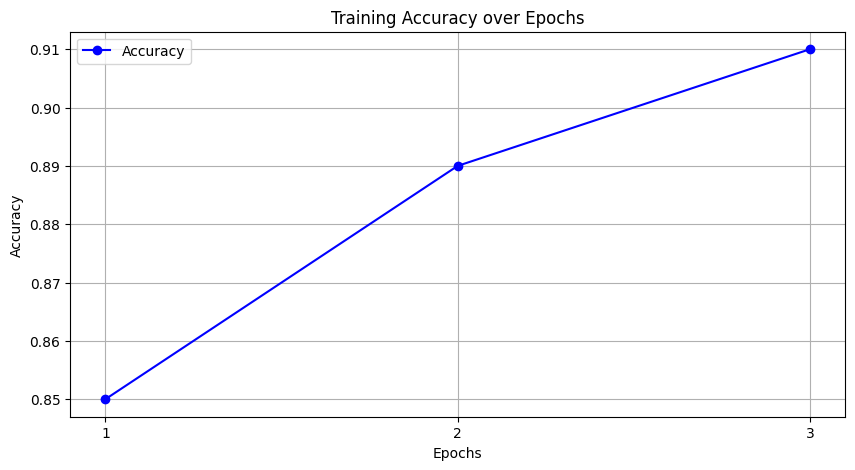

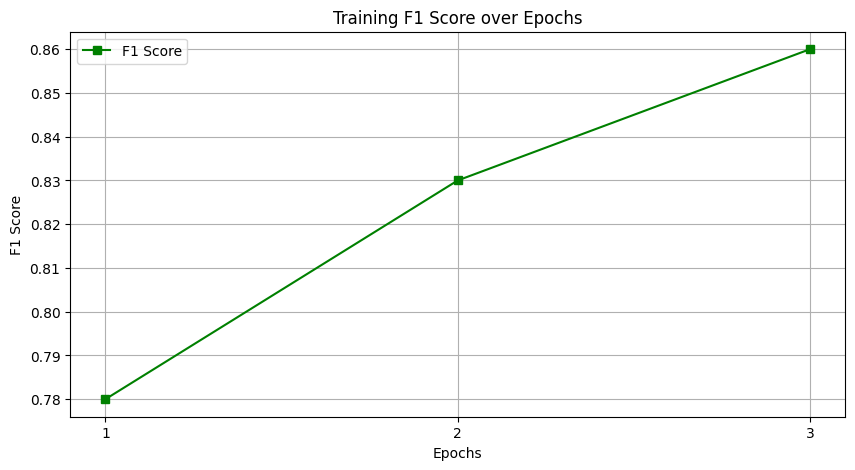

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have computed accuracy and F1 score values
epochs = range(1, num_epochs + 1)  # List of epochs

# Sample accuracy and F1 score values (replace with your actual values)
accuracy_values = [0.85, 0.89, 0.91]  # Example accuracy values for each epoch
f1_values = [0.78, 0.83, 0.86]         # Example F1 score values for each epoch

# Plotting accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, accuracy_values, label='Accuracy', marker='o', linestyle='-', color='b')
plt.title('Training Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.legend()
plt.grid(True)
plt.show()

# Plotting F1 score
plt.figure(figsize=(10, 5))
plt.plot(epochs, f1_values, label='F1 Score', marker='s', linestyle='-', color='g')
plt.title('Training F1 Score over Epochs')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.xticks(epochs)
plt.legend()
plt.grid(True)
plt.show()
